This script allows an AI to 'learn' what the optimal long/short portfolio is. It does this by:
1. Taking expected returns. These are a combination of my intrinsic fundamental analysis and historic & market adjustments.

2. Taking expected correlations. These are the result of historic correlations and an adjustment to move correlations back to historic averages.

3. Simulating 5000 returns for each stock via Monte Carlo. The simulator does this by randomising the returns and correlations for each period. These are randomised around the mean of the expected returns and correlations from steps 1) and 2). It then creates Cholesky Matrixes and random errors. 

4. An AI learns which sets of long/short weights are through decision trees. For each AI portfolio, the AI starts off with a weight of 0% on each stock. It then randomlly allocates x% to a stock and looks at the risk & reward charateristics of new portfolio when put through the 5000 sims. If the portfolio is better it keeps the new x% weight, if it is worse it tries a -x% weight. This process repeats many times until an 'optimal' portfolio is reached.

5. ~30 AI portfolios are created this way. They are then filtered based factors such as their betas to the market. A final list of AI portfolios remains. These are ranked from best to worst. 

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import pandas.io.data as web
from pandas.io.data import DataReader
import matplotlib.pyplot as plt
from scipy.stats import norm
import datetime as dt
import random
import scipy
import scipy.linalg
from scipy import stats
import statsmodels.api as sm
from decimal import Decimal
import itertools
from itertools import product

%matplotlib inline 

/Users/christopherwaller/anaconda/lib/python2.7/site-packages/pandas/io/data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [2]:
xls_file = pd.ExcelFile('/Users/christopherwaller/Library/Mobile Documents/com~apple~CloudDocs/Last copy of Samsung Laptop files/Documents/Documents/Investment/Avalon/Portfolio.xlsx')
xls_portfolio_sheet = xls_file.parse('Portfolio')
portfolio_sheet = DataFrame(xls_portfolio_sheet)

In [3]:
symbols = list(portfolio_sheet.Ticker)
directions = list(portfolio_sheet.Direction)

In [4]:
historic_prices = DataFrame()

#gives pricing data since Jan-2010.
for sym in symbols:
    historic_prices[sym] = web.DataReader(sym, data_source='yahoo',
                              end=dt.datetime.now())['Adj Close']
    
historic_daily_returns = np.log(historic_prices/historic_prices.shift(1))

# Exp returns

In [5]:
intrinsic_risks = list(portfolio_sheet.risk)
intrinsic_rewards = list(portfolio_sheet.reward)

Functions

In [6]:
def returns(stock, freq, start, end):
    daily_prices = web.get_data_yahoo(stock, start=start, end=end)['Adj Close']  
    dates = pd.date_range(start, end, freq=freq)
    prices_used = daily_prices.reindex(dates, method='ffill')
    price_change = np.log(prices_used/prices_used.shift(1)).dropna()
    return np.round((price_change),3)

#e.g: returns(symbols, 'Q', dt.datetime(1960,1,1), dt.datetime.now())

def returns_diff(stock, benchmark, freq, start, end):
    return (returns(stock, freq, start, end) - returns(benchmark, freq, start, end)).dropna()

#e.g: returns_diff('AAPL', '^GSPC', 'Q', dt.datetime(1960,1,1), dt.datetime.now())

def risk(stock, benchmark, freq, start, end):
    if benchmark == 'N/A':
        Data = returns(stock, freq, start, end)
    else:
        Data = returns_diff(stock, benchmark, freq, start, end)
    bins1=500
    counts, bins = np.histogram(Data, bins=bins1, range=(-1, 1))
    b = np.round(np.linspace(-1, 1, bins1), 2)
    rrs = [x * y / sum(counts) for x, y in zip(counts, bins)]
    risk = abs(sum([x for x in rrs if x <0]))
    return risk

def reward(stock, benchmark, freq, start, end):
    if benchmark == 'N/A':
        Data = returns(stock, freq, start, end)
    else:
        Data = returns_diff(stock, benchmark, freq, start, end)
    bins1=500
    counts, bins = np.histogram(Data, bins=bins1, range=(-1, 1))
    b = np.round(np.linspace(-1, 1, bins1), 2)
    rrs = [x * y / sum(counts) for x, y in zip(counts, bins)]
    risk = abs(sum([x for x in rrs if x <0]))
    reward = sum([x for x in rrs if x>0])
    return reward

def rr(stock, benchmark, freq, start, end):
    if benchmark == 'N/A':
        Data = returns(stock, freq, start, end)
    else:
        Data = returns_diff(stock, benchmark, freq, start, end)
    bins1=500
    counts, bins = np.histogram(Data, bins=bins1, range=(-1, 1))
    b = np.round(np.linspace(-1, 1, bins1), 2)
    rrs = [x * y / sum(counts) for x, y in zip(counts, bins)]
    risk = abs(sum([x for x in rrs if x <0]))
    reward = sum([x for x in rrs if x>0])
    rr = reward/abs(risk)
    return rr


def key_stats(stock, benchmark, freq, start, end):
    if benchmark == 'N/A':
        Data = returns(stock, freq, start, end)
    else:
        Data = returns_diff(stock, benchmark, freq, start, end)
    bins1=500
    counts, bins = np.histogram(Data, bins=bins1, range=(-1, 1))
    b = np.round(np.linspace(-1, 1, bins1), 2)
    rrs = [x * y / sum(counts) for x, y in zip(counts, bins)]
    risk = abs(sum([x for x in rrs if x <0]))
    reward = sum([x for x in rrs if x>0])
    rr = reward/abs(risk)
    key_stats = {
    'mean': np.mean(Data),
    'stdev': np.std(Data),
    'risk': risk,
    'reward': reward,
    'rr': rr
    }
    df_key_stats = np.round(DataFrame(key_stats, index=[stock]),3)
    cols = df_key_stats.columns.tolist()
    cols2 = cols[0:1] + cols[4:5] + cols[1:4]
    df_key_stats = df_key_stats[cols2].T
    return df_key_stats

def portfolio_risks(symbols, benchmark, freq, start, end):
    portfolio_risks = []
    for sym in symbols:
        try:
            portfolio_risks.append(risk(sym, benchmark, freq, start, end))
        except:
            portfolio_risks.append(0)
    return portfolio_risks

def portfolio_rewards(symbols, benchmark, freq, start, end):
    portfolio_rewards = []
    for sym in symbols:
        try:
            portfolio_rewards.append(reward(sym, benchmark, freq, start, end))
        except:
            portfolio_rewards.append(0)
    return portfolio_rewards

def portfolio_rrs(symbols, benchmark, freq, start, end):
    portfolio_rrs = []
    for sym in symbols:
        try:
            portfolio_rrs.append(rr(sym, benchmark, freq, start, end))
        except:
            portfolio_rrs.append(0)
    return portfolio_rrs

In [7]:
mkt_risk = [0.04] * len(symbols)
mkt_reward = [0.11] * len(symbols)

In [8]:
def portfolio_stats(symbols, benchmark, freq, start, end):
    portfolio_stats = {
        'Direction': directions,
        'mkt_risk': mkt_risk,
        'hist_risk': portfolio_risks(symbols, benchmark, freq, start, end),
        'intrinsic_risk': intrinsic_risks,
        'mkt_reward': mkt_reward,
        'hist_reward': portfolio_rewards(symbols, benchmark, freq, start, end),
        'intrinsic_reward': intrinsic_rewards,
        #'rr': portfolio_rrs(symbols, benchmark, freq, start, end)
    }
    return portfolio_stats

df_portfolio = DataFrame(portfolio_stats(symbols, 'N/A', 'A', dt.datetime(2005,1,1), dt.datetime.now()), index=symbols)

Cleaning historical numbers

In [9]:
df_portfolio.ix[df_portfolio.hist_reward == 0, 'hist_reward'] = 0.11
df_portfolio.ix[df_portfolio.hist_risk == 0, 'hist_risk'] = 0.04

df_portfolio.ix[df_portfolio.hist_reward < 0.06, 'hist_reward'] = 0.06
df_portfolio.ix[df_portfolio.hist_risk < 0.02, 'hist_risk'] = 0.02

df_portfolio.ix[df_portfolio.hist_reward > 0.3, 'hist_reward'] = 0.3
df_portfolio.ix[df_portfolio.hist_risk > 0.3, 'hist_risk'] = 0.3


Adjusting intinsic value numbers

In [10]:
#Investor stats:

investor_mean = 0.132
investor_std = 0.314
investor_rr = 2.8
investor_certainty_reward = 0.33
investor_certainty_risk = 0.67

In [11]:
df_portfolio.ix[df_portfolio.Direction == 'Long', 'intrinsic_reward'] = df_portfolio['intrinsic_reward'] * investor_certainty_reward
df_portfolio.ix[df_portfolio.Direction == 'Long', 'intrinsic_risk'] = df_portfolio['intrinsic_risk'] * investor_certainty_risk

df_portfolio.ix[df_portfolio.Direction == 'Short', 'intrinsic_reward'] = df_portfolio['intrinsic_reward'] * investor_certainty_risk
df_portfolio.ix[df_portfolio.Direction == 'Short', 'intrinsic_risk'] = df_portfolio['intrinsic_risk'] * investor_certainty_reward

Creating Exp numbers

In [12]:
#loadings

H = 0.2 #historic
M = 0.2 #market
I = 0.6 #Intrinsic

exp_risk = M*df_portfolio['mkt_risk'] + H*df_portfolio['hist_risk'] + I*df_portfolio['intrinsic_risk']
exp_reward = M*df_portfolio['mkt_reward'] + H*df_portfolio['hist_reward'] + I*df_portfolio['intrinsic_reward']
exp_rr = exp_reward/exp_risk

In [13]:
df_portfolio['E_risk'] = exp_risk
df_portfolio['E_rwrd'] = exp_reward
df_portfolio['E_rr'] = exp_rr

In [14]:
cols = ['E_rr', 'E_rwrd', 'E_risk', 'intrinsic_reward', 'intrinsic_risk', 'hist_reward', 'hist_risk', 'mkt_reward', 'mkt_risk']
df_portfolio = df_portfolio[cols]
col2 = ['Direction']
df_portfolio = pd.concat([np.round(df_portfolio,2), DataFrame(directions, index=symbols, columns=col2)], axis=1)
cols2 = ['Direction', 'E_rr', 'E_rwrd', 'E_risk', 'intrinsic_reward', 'intrinsic_risk', 'hist_reward', 'hist_risk', 'mkt_reward', 'mkt_risk']
df_portfolio = df_portfolio[cols2]
df_portfolio

,Direction,E_rr,E_rwrd,E_risk,intrinsic_reward,intrinsic_risk,hist_reward,hist_risk,mkt_reward,mkt_risk
^GSPC,Long,2.54,0.11,0.04,0.11,0.04,0.10,0.05,0.11,0.04
OIL,Long,0.70,0.09,0.13,0.10,0.12,0.06,0.26,0.11,0.04
NTT,Long,7.44,0.20,0.03,0.27,0.01,0.11,0.06,0.11,0.04
JNJ,Long,6.58,0.21,0.03,0.29,0.03,0.09,0.02,0.11,0.04
HCA,Long,5.15,0.21,0.04,0.22,0.05,0.30,0.02,0.11,0.04
NXTM,Short,0.85,0.09,0.11,0.06,0.11,0.20,0.18,0.11,0.04
GOOGL,Long,2.80,0.14,0.05,0.13,0.04,0.22,0.09,0.11,0.04
CRST.L,Long,9.78,0.27,0.03,0.33,0.02,0.24,0.04,0.11,0.04
BVS.L,Long,2.14,0.13,0.06,0.13,0.05,0.14,0.10,0.11,0.04
TW.L,Long,1.39,0.11,0.08,0.06,0.08,0.26,0.11,0.11,0.04


In [15]:
#risk and reward values for each stock:

target_risks = list(exp_risk)
target_rewards = list(exp_reward)

# Exp Correlations

Historic correlations

In [16]:
#using trailing 1 year correlations
historic_correlations = DataFrame(historic_daily_returns[-251:].corr())

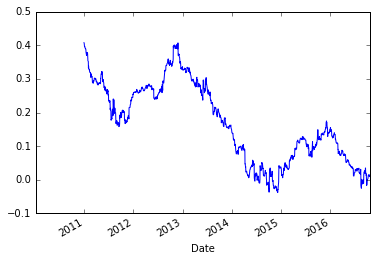

In [17]:
def rolling_corr(x, y, z):
    pd.rolling_corr(historic_daily_returns[x], historic_daily_returns[y], z).plot()

    
rolling_corr('^GSPC', 'AEM', 250)

Adjustments

In [18]:
#adjusting correlations to reflect mid-cycle of 0.6
current_corr = np.mean(historic_correlations['^GSPC']) #current average corr to S&P
distance_from_midcycle = 0.6 - current_corr
adjustment_factor = min(2.0, 1.0/(1.0 + 2 * distance_from_midcycle)) #adjusting correlations back to cycle mean, allowing for some persistence.

cycle_adjustment = lambda x: min(max(0.05, x**(adjustment_factor) ), 1) #add distance_from_midcycle


exp_corrs = historic_correlations.applymap(cycle_adjustment)
print 'Trailing 1 year corr to S&P:', np.round(current_corr, 2)
print 'Distance to mid-cycle (0.6):', np.round(distance_from_midcycle, 2)
print 'Exp corr to S&P used:', np.round(np.mean(exp_corrs['^GSPC']), 2)
np.round(exp_corrs, 2)

Trailing 1 year corr to S&P: 0.43
Distance to mid-cycle (0.6): 0.17
Exp corr to S&P used: 0.52


,^GSPC,OIL,NTT,JNJ,HCA,NXTM,GOOGL,CRST.L,BVS.L,TW.L,...,OEC,URI,HP,APC,XEC,SWN,WPX,SM,EPE,GAS.MC
^GSPC,1.00,0.49,0.52,0.71,0.63,0.45,0.73,0.49,0.52,0.52,...,0.51,0.64,0.64,0.66,0.65,0.35,0.52,0.53,0.40,0.56
OIL,0.49,1.00,0.28,0.22,0.26,0.24,0.18,0.29,0.28,0.28,...,0.42,0.43,0.67,0.61,0.68,0.45,0.60,0.56,0.58,0.23
NTT,0.52,0.28,1.00,0.43,0.33,0.28,0.48,0.05,0.05,0.05,...,0.05,0.15,0.27,0.32,0.28,0.12,0.21,0.21,0.09,0.26
JNJ,0.71,0.22,0.43,1.00,0.37,0.38,0.53,0.21,0.21,0.22,...,0.15,0.37,0.35,0.36,0.47,0.05,0.27,0.21,0.15,0.39
HCA,0.63,0.26,0.33,0.37,1.00,0.35,0.44,0.35,0.44,0.39,...,0.39,0.51,0.42,0.50,0.47,0.40,0.45,0.45,0.38,0.46
NXTM,0.45,0.24,0.28,0.38,0.35,1.00,0.34,0.22,0.23,0.23,...,0.32,0.37,0.22,0.30,0.20,0.15,0.23,0.27,0.19,0.34
GOOGL,0.73,0.18,0.48,0.53,0.44,0.34,1.00,0.33,0.37,0.39,...,0.28,0.21,0.29,0.36,0.31,0.05,0.13,0.19,0.05,0.39
CRST.L,0.49,0.29,0.05,0.21,0.35,0.22,0.33,1.00,0.92,0.93,...,0.42,0.46,0.30,0.36,0.32,0.22,0.31,0.26,0.24,0.47
BVS.L,0.52,0.28,0.05,0.21,0.44,0.23,0.37,0.92,1.00,0.94,...,0.46,0.48,0.32,0.34,0.35,0.22,0.31,0.29,0.23,0.54
TW.L,0.52,0.28,0.05,0.22,0.39,0.23,0.39,0.93,0.94,1.00,...,0.37,0.45,0.29,0.30,0.32,0.18,0.27,0.26,0.17,0.56


In [19]:
#creating n_sim number of error values for each stock:

n_sims = 5000

errors = DataFrame(np.random.normal(0, 0.163, (n_sims, len(symbols)))) 

In [20]:
n = n_sims 

regimes = []
for x in range(n):
    x = np.random.normal(0, 0.1) #use normal or lognormal??
    regimes.append(x)

In [21]:
#if the first eigenvalue for the correlation matrix is negative, find nearest positive
#this prevents the cholesky decomposition (L and U) returning an error because the matrix is not positive definite

def nearPSD(A,epsilon=0):  #delete =0?
   n = A.shape[0]
   eigval, eigvec = np.linalg.eig(A)
   val = np.matrix(np.maximum(eigval,epsilon))
   vec = np.matrix(eigvec)
   T = 1/(np.multiply(vec,vec) * val.T)
   T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)) )))
   B = T * vec * np.diag(np.array(np.sqrt(val)).reshape((n)))
   out = B*B.T
   return(out)

exp_corrs2 = []
for p in range(n):
    e_corr = exp_corrs.applymap(lambda x: min(max(0.05, x ** ((1 - 3 * float(regimes[p]))/1.0)), 1))
    if np.linalg.eigvalsh(scipy.array(exp_corrs.applymap(lambda x: min(max(0.05, x ** ((1 - 3 * float(regimes[p]))/1.0)), 1)).values.T.tolist()))[0]>0:
        e_corr = e_corr
    else:
        if min(np.linalg.eig(nearPSD(e_corr,0.001))[0])>0: #if e_corr is not a positive definite matrix then find nearest one
            e_corr = nearPSD(e_corr,0.001)
        else:
            #if still doesn't work than just use exp_corrs (happens v.v. infrequently so doesn't skew results):
            e_corr = exp_corrs
    exp_corrs2.append(DataFrame(e_corr, columns=symbols, index=symbols))

#creating list of cholesky matrixes:    
As = []
for p in range(n):
    a = scipy.array(exp_corrs2[p].values.T.tolist())
    As.append(a)

Ls = []
for p in range(n):
    l = scipy.linalg.cholesky(As[p], lower=True)
    Ls.append(l)

Us = []
for p in range(n):
    u = scipy.linalg.cholesky(As[p], lower=False)
    Us.append(u)  

Checking that correlation results make sense

In [22]:
#testing
Cor = []
for p in range(n):
    x = np.mean(exp_corrs2[p]['^GSPC']) 
    Cor.append(x)

print 'Exp average corr to S&P:', np.round(np.mean(exp_corrs['^GSPC']), 2)
print 'Model corr to S&P for percentile:', np.round(np.percentile(Cor, 83), 2)
print 'Diff:', np.round(np.percentile(Cor, 83) - np.mean(exp_corrs['^GSPC']), 2)

Exp average corr to S&P: 0.52
Model corr to S&P for percentile: 0.62
Diff: 0.1


In [23]:
corr_pair = []
stock_a = 'TSCO.L'
stock_b = 'SBRY.L'

for p in range (n):
    x = exp_corrs2[p][stock_a][stock_b]
    corr_pair.append(x)
print 'Expected corr between pair:', np.round(exp_corrs[stock_a][stock_b], 2)
print 'Actual average corr in model:', np.round(np.mean(corr_pair), 2)
print 'Actual std of corr in model:', np.round(np.std(corr_pair), 2)

Expected corr between pair: 0.65
Actual average corr in model: 0.65
Actual std of corr in model: 0.09


Creating correlated errors

In [24]:
#create n_sim correlated errors for each stock using errors and correlation matrix from above:

correlated_errors = []
for p in range(n):
    c = np.dot(errors.loc[p], Us[p])
    correlated_errors.append(c)

correlated_errors = DataFrame(correlated_errors, columns=symbols)

# Exp Betas

In [25]:
betas = np.round(DataFrame(historic_daily_returns[-251:].cov()/historic_daily_returns[-251:].var()),2)

In [26]:
exp_betas = betas

# Calibration

In [27]:
weights = 1.0/n_sims
weights = [weights] * n_sims

In [28]:
def calibrate(data, target_risk, target_reward):
    model = []
    actual_risk = abs(sum([x*y for x, y in zip(data, weights) if x <0]))
    actual_reward = abs(sum([x*y for x, y in zip(data, weights) if x >0])) 
    for x in data:              
        if x < 0:
            d = x - 2*(target_risk - actual_risk)
        else:
            d = x + 2*(target_reward - actual_reward)
        model.append(d)
    return model

def sim(data, n):
    model = []
    for p in range(n): 
        d = calibrate(data[symbols[p]], target_risks[p], target_rewards[p])
        model.append(d)
    return model

In [29]:
sim_output = DataFrame(sim(correlated_errors, len(symbols)), index=symbols).T  

In [30]:
def model_risk(model, weights):
    return abs(sum([x*y for x, y in zip(model, weights) if x <0]))

def model_reward(model, weights):
    return abs(sum([x*y for x, y in zip(model, weights) if x >0]))

def model_rr(model, weights):
    return model_reward(model, weights)/model_risk(model, weights)

# AI

In [31]:
def learn_weights(incoming_ws, w_tested, n_stocks): #ws = weights, w_tested=0.1, n_stocks = len(symbols)
    r = [i for i in range(len(symbols))]
    random.shuffle(r) #shuffling the order of symbols so that function goes through them at random
    length = [1.0/n_sims]*n_sims
    model_rrs = [0]*(n_stocks) #!!!!!!!
    ws = [i for i in incoming_ws]
    for p in range(n_stocks): #!!!!!!!!!    
        ws[r[p]] += w_tested #add a weight
        weighted_output = sim_output*ws
        prets = weighted_output.sum(axis=1) #n number of portolio sims with the ws from above
        model_rrs[p] = model_rr(prets, length)
        if model_rrs[p] == max(model_rrs):
            ws[r[p]] += 0
        else:
            ws[r[p]] += -w_tested*2 #subtracting added weight, then making it negative?? should this be done separately??
            weighted_output = sim_output*ws
            prets = weighted_output.sum(axis=1) #n number of portolio sims with the ws from above
            model_rrs_test = 0
            model_rrs_test = model_rr(prets, length) 
            if model_rrs_test >= max(model_rrs): #testing if shorting stock gives better r/r then previous max
                ws[r[p]] += 0
            else: #if neither short nor long increases r/r
                ws[r[p]] += w_tested #add back weight so weight now 0.
    return ws

def ai_portfolios(ai_sims): #ai_sims = n number of simmed portfolios
    ai_weights = []
    s1=s2=s3=s4=s5=s6= [0] * len(symbols)
    for i in range(ai_sims): 
        s1[i] = learn_weights([0] * len(symbols), 0.1, len(symbols))
        s2[i] = learn_weights(s1[i], 0.05, len(symbols))
        s3[i] = learn_weights(s2[i], 0.03, len(symbols))
        s4[i] = learn_weights(s3[i], 0.03, len(symbols))
        s5[i] = learn_weights(s4[i], 0.02, len(symbols))
        s6[i] = learn_weights(s5[i], 0.01, len(symbols))
        ai_weights.append(s6[i])
    return ai_weights

ai_n = len(symbols)
ai_ports = np.round(DataFrame(ai_portfolios(ai_n), columns=symbols), 2)

# Cleaning portfolio results

Calculating portfolio characteristics

In [32]:
def p_betas(exp_betas, data, n):
    model = []
    for p in range(n): #change to len(symbols)
        d = [sum(data.T[p] * exp_betas)]
        model.append(d)
    return model

#actual_beta = sum([x * y for x, y in zip(exp_betas['^GSPC'], ai_ports[1])])
mkt_betas = DataFrame(p_betas(exp_betas['^GSPC'], ai_ports, ai_n), columns=['Mkt β'])
oil_betas = DataFrame(p_betas(exp_betas['OIL'], ai_ports, ai_n), columns=['Oil β'])

In [33]:
def p_rewards(weights, n): #weights=ai_ports, n=ai_n
    model = []
    for p in range(n): #change to len(symbols)
        length = [1.0/n_sims]*n_sims
        weighted_output = weights.T[p] * sim_output
        prets = weighted_output.sum(axis=1)
        model.append(model_reward(prets, length))
    return model

def p_risks(weights, n): #weights=ai_ports, n=ai_n
    model = []
    for p in range(n): #change to len(symbols)
        length = [1.0/n_sims]*n_sims
        weighted_output = weights.T[p] * sim_output
        prets = weighted_output.sum(axis=1)
        model.append(model_risk(prets, length))
    return model

p_rewards = DataFrame(p_rewards(ai_ports, ai_n), columns=['Reward'])
p_risks = DataFrame(p_risks(ai_ports, ai_n), columns=['Risk'])

Removing unsuitable portfolios

In [34]:
sum_output = np.round(pd.concat([p_rewards, p_risks, mkt_betas, oil_betas, ai_ports], axis=1).T, 2)

sum_output = sum_output.T[sum_output.T['Mkt β'] > -0.2].T
sum_output = sum_output.T[sum_output.T['Mkt β'] < 0.2].T

sum_output = sum_output.T[sum_output.T['Oil β'] > -0.2].T
sum_output = sum_output.T[sum_output.T['Oil β'] < 0.2].T

/Users/christopherwaller/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1122: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine


# Portfolio analysis

In [35]:
single_stock_characteristics = pd.concat([df_portfolio[['E_rr','E_rwrd', 'E_risk']],exp_betas['^GSPC'], exp_betas['OIL']], axis=1)
single_stock_characteristics.columns = ['E_rr', 'E_rwrd', 'E_risk', 'Mkt β', 'Oil β']

In [36]:
means = np.round(DataFrame(sum_output.mean(axis=1), columns=['μ']), 2)
stds = np.round(DataFrame(sum_output.std(axis=1), columns=['σ']), 2)

sum_output_sorted = sum_output.T.sort_values('Reward', ascending=True).T #should sort by rr but not representative.

port_characteristics = pd.concat([means, stds], axis=1)
blank_column = DataFrame([""]*len(sum_output), index=sum_output.index, columns=[''])
port_summary = pd.concat([port_characteristics, blank_column, single_stock_characteristics, blank_column, sum_output_sorted], axis=1)
port_summary = port_summary.replace(np.nan,' ', regex=True)

/Users/christopherwaller/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1907: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target._values)


Summary

In [37]:
print "PORTFOLIO AI RESULTS"
print "Number of sims for each stock:", n_sims
print "Number of portfolios sims:", ai_n
print "Number of portfolios sims retained:", len(sum_output.columns)
port_summary

PORTFOLIO AI RESULTS
Number of sims for each stock: 5000
Number of portfolios sims: 31
Number of portfolios sims retained: 11


,μ,σ,,E_rr,E_rwrd,E_risk,Mkt β,Oil β,,8,28,1,11,24,6,22,30,9,25,13
Mkt β,-0.10,0.09,,,,,,,,-0.09,-0.15,-0.19,-0.15,-0.15,0.03,-0.15,0.04,-0.19,0.03,-0.10
Oil β,-0.06,0.03,,,,,,,,-0.04,-0.03,-0.04,-0.05,-0.07,-0.06,-0.12,-0.06,-0.11,-0.02,-0.06
Reward,0.27,0.03,,,,,,,,0.23,0.24,0.25,0.25,0.26,0.28,0.28,0.28,0.29,0.30,0.32
Risk,0.00,0.00,,,,,,,,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
^GSPC,-0.07,0.11,,2.54,0.11,0.04,1,0.12,,0.02,-0.14,-0.07,-0.06,0.04,-0.18,-0.03,-0.24,0.12,-0.15,-0.10
OIL,0.08,0.03,,0.7,0.09,0.13,1.23,1,,0.06,0.09,0.13,0.10,0.06,0.04,0.03,0.07,0.10,0.08,0.12
NTT,0.16,0.04,,7.44,0.2,0.03,0.68,0.09,,0.11,0.15,0.15,0.11,0.14,0.20,0.16,0.14,0.16,0.24,0.15
JNJ,0.14,0.04,,6.58,0.21,0.03,0.6,0.04,,0.10,0.11,0.15,0.14,0.15,0.15,0.13,0.11,0.09,0.19,0.24
HCA,0.16,0.03,,5.15,0.21,0.04,0.98,0.09,,0.17,0.10,0.15,0.10,0.17,0.19,0.18,0.19,0.18,0.17,0.18
NXTM,-0.09,0.04,,0.85,0.09,0.11,1.03,0.14,,-0.10,-0.05,-0.02,-0.12,-0.09,-0.06,-0.08,-0.09,-0.14,-0.04,-0.17
